In [3]:
import os

current_directory = os.getcwd()
print(f"현재 작업 디렉토리: {current_directory}")


현재 작업 디렉토리: /Users/yongjunchoi/Documents/GitHub/Research/Research/Polytomy/Codes/ipynb


In [4]:
os.chdir('/Users/yongjunchoi/Documents/GitHub/Research/Research')

# Tree Statistics

In [5]:
import dendropy
import pandas as pd
import math

# -----------------------------
# Tree height (edge 수 기준)
def height_in_edges(tree):
    max_depth = 0
    def dfs(nd, depth):
        nonlocal max_depth
        if nd.is_leaf():
            max_depth = max(max_depth, depth)
        for c in nd.child_nodes():
            dfs(c, depth+1)
    dfs(tree.seed_node, 0)
    return max_depth

# -----------------------------
# Colless index
def colless_index(tree):
    """
    Computes Colless index: sum of absolute differences in leaf counts
    for all internal nodes.
    """
    def count_leaves(node):
        if node.is_leaf():
            return 1
        return sum(count_leaves(c) for c in node.child_nodes())

    def colless_node(node):
        if node.is_leaf() or len(node.child_nodes()) < 2:
            return 0
        left, right = node.child_nodes()[:2]  # binary assumption
        nl = count_leaves(left)
        nr = count_leaves(right)
        return abs(nl - nr) + colless_node(left) + colless_node(right)

    return colless_node(tree.seed_node)

# -----------------------------
# Sackin index
def sackin_index(tree):
    """
    Computes Sackin index: sum of depths of all leaf nodes
    """
    def leaf_depth_sum(node, depth=0):
        if node.is_leaf():
            return depth
        return sum(leaf_depth_sum(c, depth+1) for c in node.child_nodes())

    return leaf_depth_sum(tree.seed_node)

# -----------------------------
# Root split 계산 함수
def root_split(tree):
    """
    Returns a string 'n_left:n_right' indicating the number of leaf nodes
    in the left and right child of the root.
    Handles:
      - binary trees
      - comb trees (1 child)
      - single leaf trees (0 child)
    """
    root_children = tree.seed_node.child_nodes()
    if len(root_children) >= 2:
        n_left = len(root_children[0].leaf_nodes())
        n_right = len(root_children[1].leaf_nodes())
    elif len(root_children) == 1:
        n_left = len(root_children[0].leaf_nodes())
        n_right = 0
    else:
        n_left = 0
        n_right = 0

    if n_left > n_right:
        n_left, n_right = n_right, n_left

    gcd = math.gcd(n_left, n_right)
    left_s = n_left // gcd
    right_s = n_right // gcd

    return f"{left_s}:{right_s}"

# -----------------------------
# 파일 경로 리스트
paths = [
    "Polytomy/Codes/nwk/Yule_n8.nwk",
    "Polytomy/Codes/nwk/Yule_n16.nwk",
    "Polytomy/Codes/nwk/BD_l1.0_m0.0_n8.nwk",
    "Polytomy/Codes/nwk/BD_l1.0_m0.0_n16.nwk",
    "Polytomy/Codes/nwk/BD_l1.5_m0.2_n8.nwk",
    "Polytomy/Codes/nwk/BD_l1.5_m0.2_n16.nwk",
    "Polytomy/Codes/nwk/BD_l2.0_m0.4_n8.nwk",
    "Polytomy/Codes/nwk/BD_l2.0_m0.4_n16.nwk",
    "Polytomy/Codes/nwk/BD_l0.8_m0.2_n8.nwk",
    "Polytomy/Codes/nwk/BD_l0.8_m0.2_n16.nwk",
    "Polytomy/Codes/nwk/BD_l1.2_m0.4_n8.nwk",
    "Polytomy/Codes/nwk/BD_l1.2_m0.4_n16.nwk",
    "Polytomy/Codes/nwk/BD_l1.5_m0.0_n8.nwk",
    "Polytomy/Codes/nwk/BD_l1.5_m0.0_n16.nwk",
    "Polytomy/Codes/nwk/BetaSplitting_b-2.0_n8.nwk",
    "Polytomy/Codes/nwk/BetaSplitting_b-2.0_n16.nwk",
    "Polytomy/Codes/nwk/BetaSplitting_b-1.5_n8.nwk",
    "Polytomy/Codes/nwk/BetaSplitting_b-1.5_n16.nwk",
    "Polytomy/Codes/nwk/BetaSplitting_b-1.0_n8.nwk",
    "Polytomy/Codes/nwk/BetaSplitting_b-1.0_n16.nwk",
    "Polytomy/Codes/nwk/BetaSplitting_b-0.5_n8.nwk",
    "Polytomy/Codes/nwk/BetaSplitting_b-0.5_n16.nwk",
    "Polytomy/Codes/nwk/BetaSplitting_b0.0_n8.nwk",
    "Polytomy/Codes/nwk/BetaSplitting_b0.0_n16.nwk",
    "Polytomy/Codes/nwk/BetaSplitting_b0.5_n8.nwk",
    "Polytomy/Codes/nwk/BetaSplitting_b0.5_n16.nwk",
    "Polytomy/Codes/nwk/BetaSplitting_b1.0_n8.nwk",
    "Polytomy/Codes/nwk/BetaSplitting_b1.0_n16.nwk",
    "Polytomy/Codes/nwk/BetaSplitting_b1.5_n8.nwk",
    "Polytomy/Codes/nwk/BetaSplitting_b1.5_n16.nwk",
    "Polytomy/Codes/nwk/BetaSplitting_b2.0_n8.nwk",
    "Polytomy/Codes/nwk/BetaSplitting_b2.0_n16.nwk",
    "Polytomy/Codes/nwk/PDA_n8.nwk",
    "Polytomy/Codes/nwk/PDA_n16.nwk"
]

# -----------------------------
# 통계 계산
rows = []

for i, path in enumerate(paths):
    model_name = f"tree{i+1}"
    with open(path) as f:
        for j, line in enumerate(f):
            line = line.strip()
            if not line:
                continue
            tree = dendropy.Tree.get(data=line, schema="newick", rooting="force-rooted")
            
            # 기존 통계
            height = height_in_edges(tree)
            colless_val = colless_index(tree)
            sackin_val = sackin_index(tree)
            
            # root split
            root_split_val = root_split(tree)
            
            rows.append({
                "model": model_name,
                "tree_index": j+1,
                "height": height,
                "colless": colless_val,
                "sackin": sackin_val,
                "root_split": root_split_val
            })

# -----------------------------
# DataFrame으로 정리
TreeStats = pd.DataFrame(rows)

# -----------------------------
# 확인
print(TreeStats.head())

   model  tree_index  height  colless  sackin root_split
0  tree1           1       6       16      32        1:7
1  tree1           2       4        3      25        1:1
2  tree1           3       5       10      28        1:3
3  tree1           4       4        5      25        3:5
4  tree1           5       5       13      31        1:7


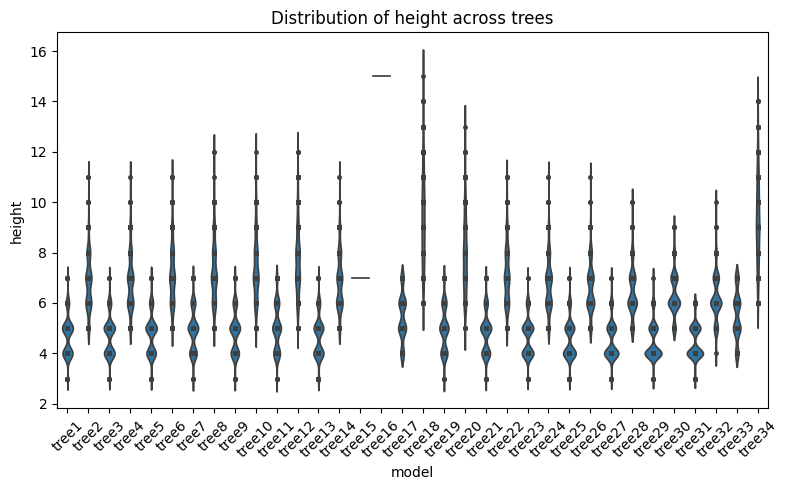

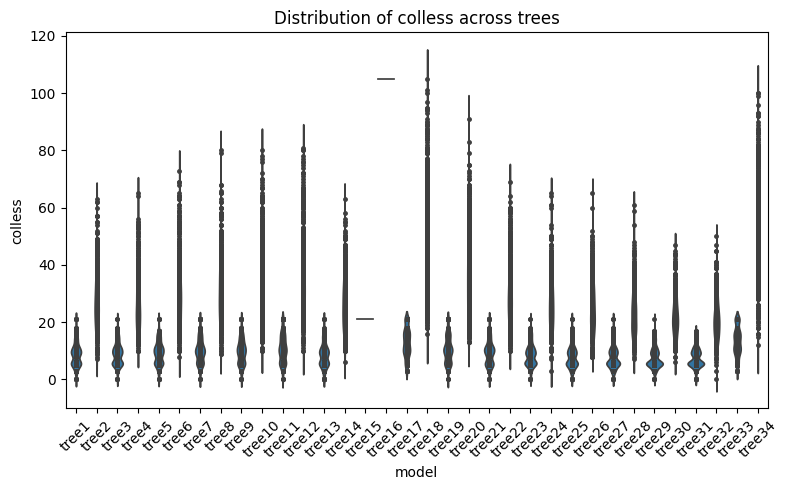

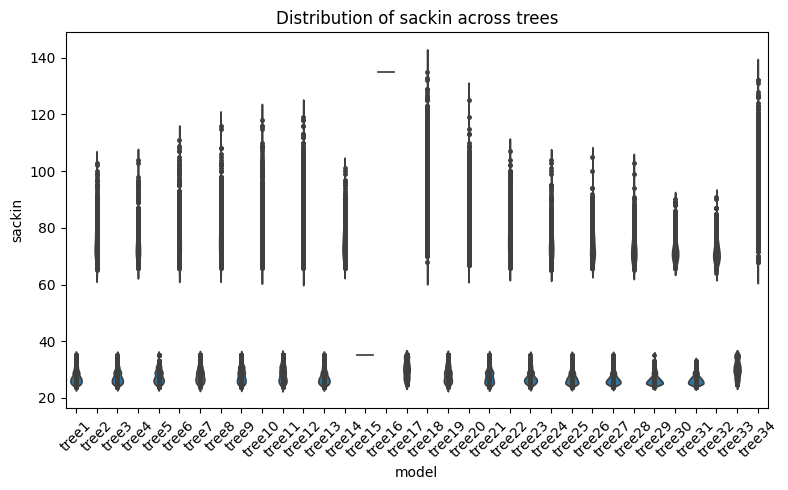

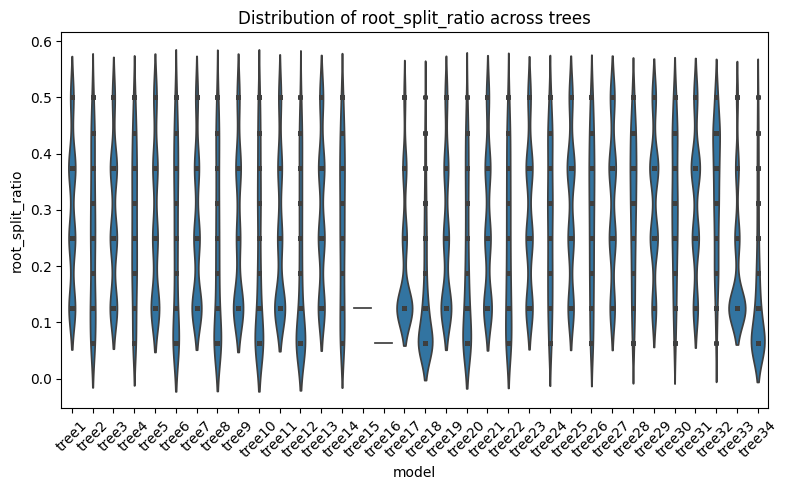

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# root_split을 ratio로 변환
TreeStats["root_split_ratio"] = TreeStats["root_split"].apply(
    lambda s: int(s.split(":")[0]) / sum(map(int, s.split(":")))
)

# 각 통계 리스트
statistics = ["height", "colless", "sackin", "root_split_ratio"]

for stat in statistics:
    plt.figure(figsize=(8, 5))
    sns.violinplot(x="model", y=stat, data=TreeStats, inner="point")
    plt.xticks(rotation=45)
    plt.title(f"Distribution of {stat} across trees")
    plt.tight_layout()
    plt.show()

# RF Distance

In [4]:
import dendropy
from dendropy.calculate import treecompare
import pandas as pd
import numpy as np

# -----------------------------
# 파일 경로 리스트
paths = [
    "Polytomy/Codes/nwk/Yule_n8.nwk",
    "Polytomy/Codes/nwk/Yule_n16.nwk",
    "Polytomy/Codes/nwk/BD_l1.0_m0.0_n8.nwk",
    "Polytomy/Codes/nwk/BD_l1.0_m0.0_n16.nwk",
    "Polytomy/Codes/nwk/BD_l1.5_m0.2_n8.nwk",
    "Polytomy/Codes/nwk/BD_l1.5_m0.2_n16.nwk",
    "Polytomy/Codes/nwk/BD_l2.0_m0.4_n8.nwk",
    "Polytomy/Codes/nwk/BD_l2.0_m0.4_n16.nwk",
    "Polytomy/Codes/nwk/BD_l0.8_m0.2_n8.nwk",
    "Polytomy/Codes/nwk/BD_l0.8_m0.2_n16.nwk",
    "Polytomy/Codes/nwk/BD_l1.2_m0.4_n8.nwk",
    "Polytomy/Codes/nwk/BD_l1.2_m0.4_n16.nwk",
    "Polytomy/Codes/nwk/BD_l1.5_m0.0_n8.nwk",
    "Polytomy/Codes/nwk/BD_l1.5_m0.0_n16.nwk",
    "Polytomy/Codes/nwk/BetaSplitting_b-2.0_n8.nwk",
    "Polytomy/Codes/nwk/BetaSplitting_b-2.0_n16.nwk",
    "Polytomy/Codes/nwk/BetaSplitting_b-1.5_n8.nwk",
    "Polytomy/Codes/nwk/BetaSplitting_b-1.5_n16.nwk",
    "Polytomy/Codes/nwk/BetaSplitting_b-1.0_n8.nwk",
    "Polytomy/Codes/nwk/BetaSplitting_b-1.0_n16.nwk",
    "Polytomy/Codes/nwk/BetaSplitting_b-0.5_n8.nwk",
    "Polytomy/Codes/nwk/BetaSplitting_b-0.5_n16.nwk",
    "Polytomy/Codes/nwk/BetaSplitting_b0.0_n8.nwk",
    "Polytomy/Codes/nwk/BetaSplitting_b0.0_n16.nwk",
    "Polytomy/Codes/nwk/BetaSplitting_b0.5_n8.nwk",
    "Polytomy/Codes/nwk/BetaSplitting_b0.5_n16.nwk",
    "Polytomy/Codes/nwk/BetaSplitting_b1.0_n8.nwk",
    "Polytomy/Codes/nwk/BetaSplitting_b1.0_n16.nwk",
    "Polytomy/Codes/nwk/BetaSplitting_b1.5_n8.nwk",
    "Polytomy/Codes/nwk/BetaSplitting_b1.5_n16.nwk",
    "Polytomy/Codes/nwk/BetaSplitting_b2.0_n8.nwk",
    "Polytomy/Codes/nwk/BetaSplitting_b2.0_n16.nwk",
    "Polytomy/Codes/nwk/PDA_n8.nwk",
    "Polytomy/Codes/nwk/PDA_n16.nwk"
]

# -----------------------------
# 공통 TaxonNamespace 생성
common_taxa = dendropy.TaxonNamespace()

# -----------------------------
# 모델별 트리 저장
all_trees = {}

for i, path in enumerate(paths):
    model_name = f"tree{i+1}"  # 또는 path에서 모델 이름 추출
    trees = []
    with open(path) as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            tree = dendropy.Tree.get(
                data=line,
                schema="newick",
                rooting="force-rooted",
                taxon_namespace=common_taxa
            )
            trees.append(tree)
    all_trees[model_name] = trees

# -----------------------------
# RF distance 행렬 계산 함수
def compute_rf_matrix_model(trees):
    n = len(trees)
    rf_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            rf = treecompare.symmetric_difference(trees[i], trees[j])
            rf_matrix[i,j] = rf
            rf_matrix[j,i] = rf
    return pd.DataFrame(rf_matrix)

rf_matrices = {}
for model_name, trees in all_trees.items():
    rf_matrices[model_name] = compute_rf_matrix_model(trees)

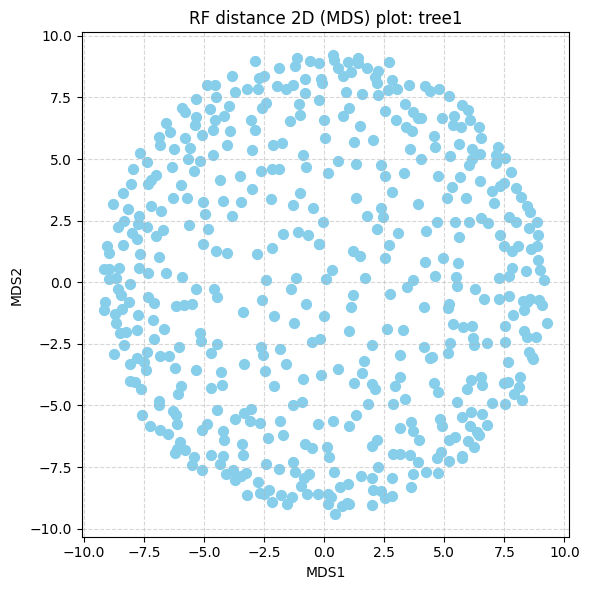

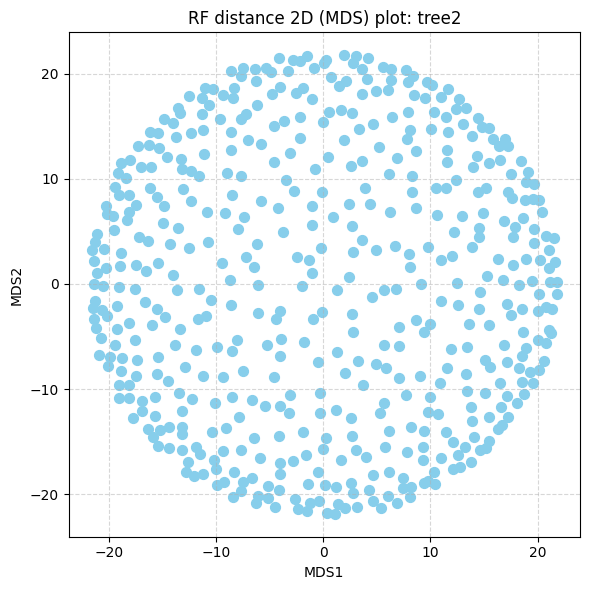

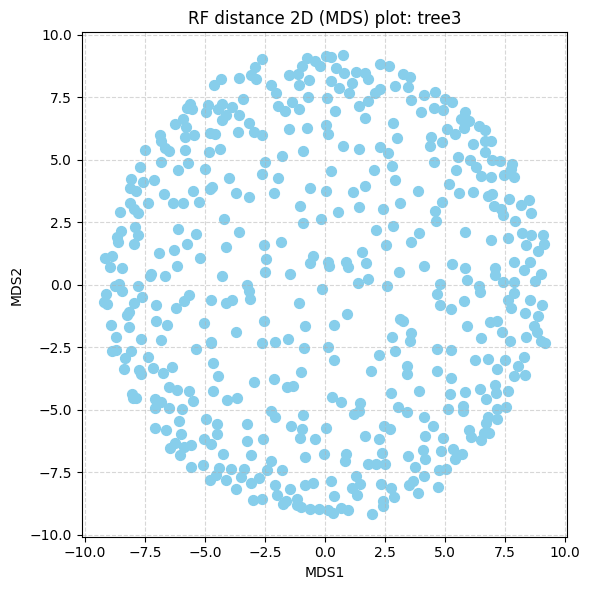

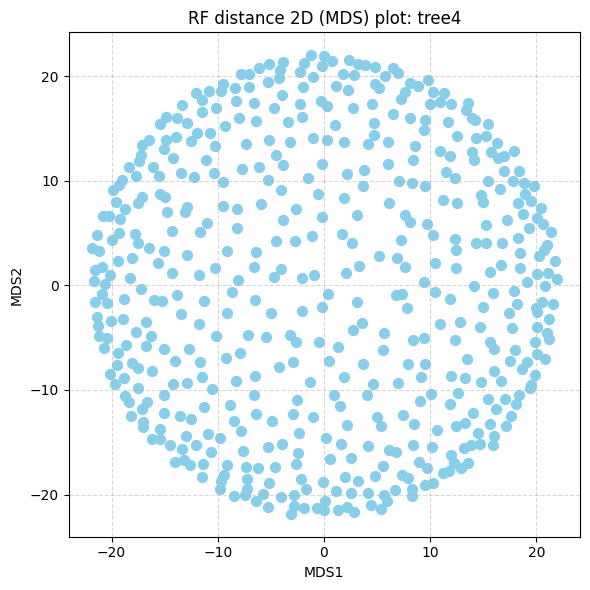

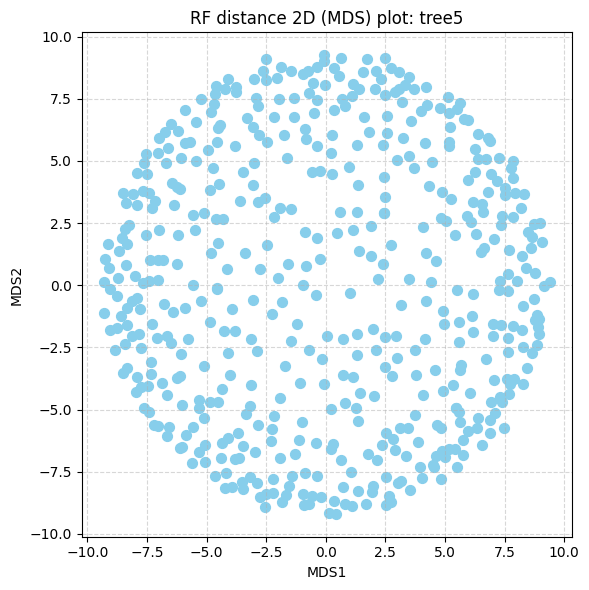

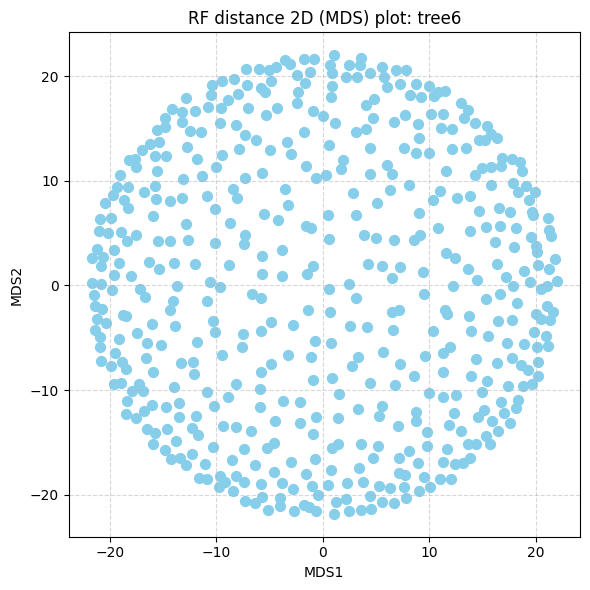

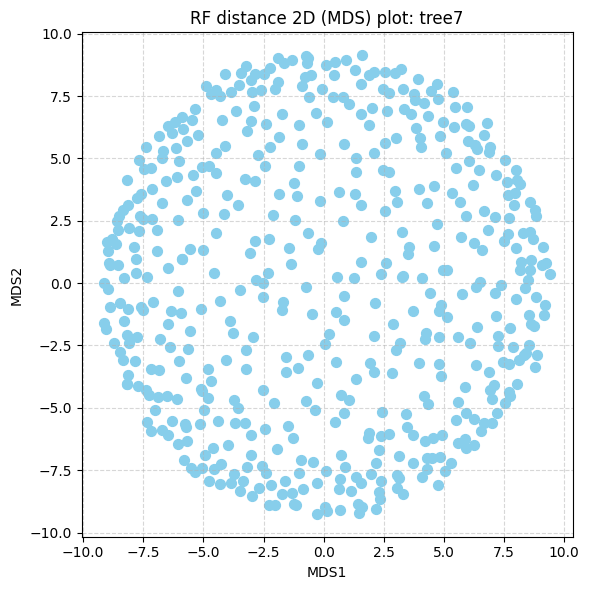

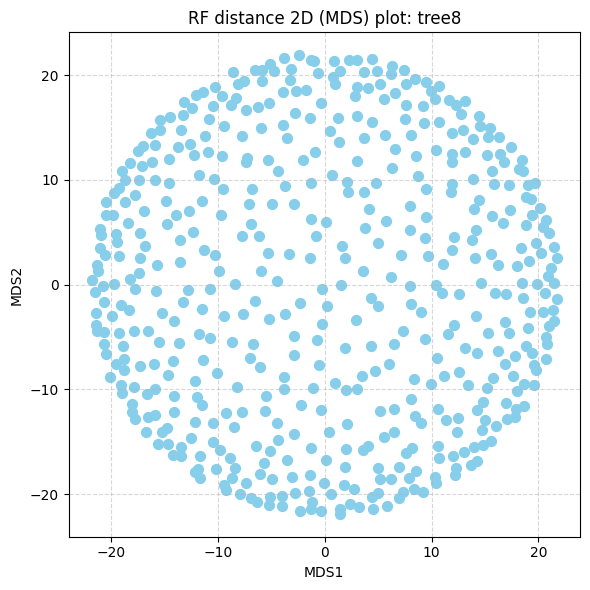

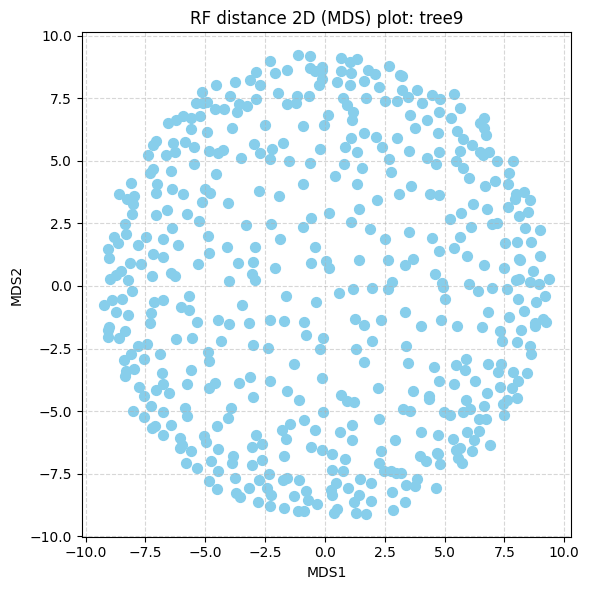

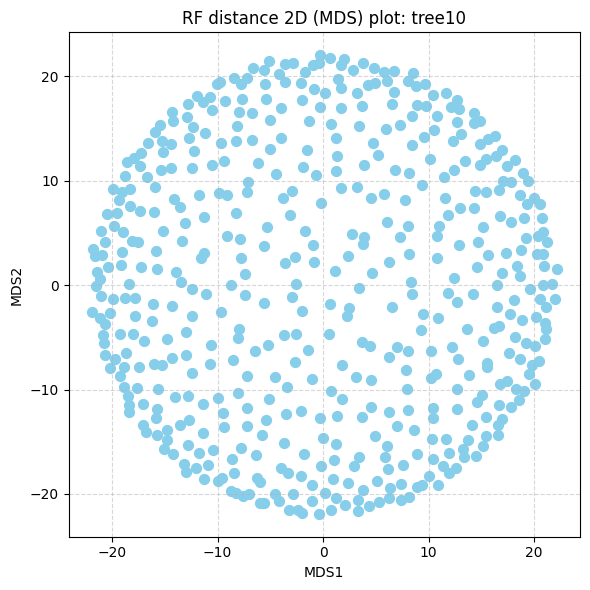

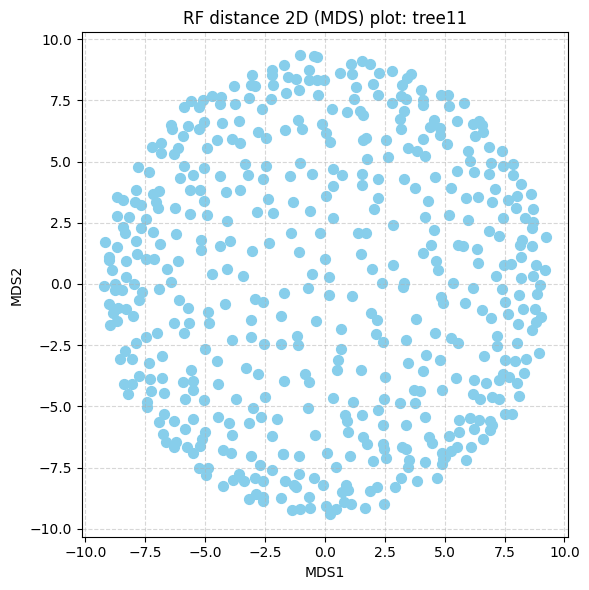

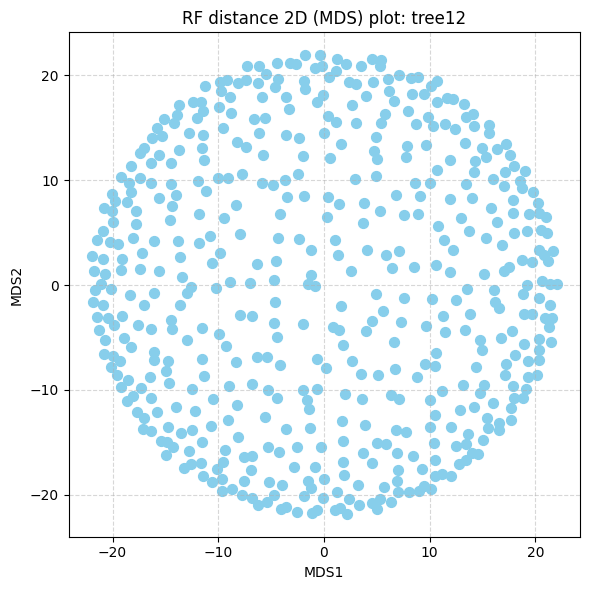

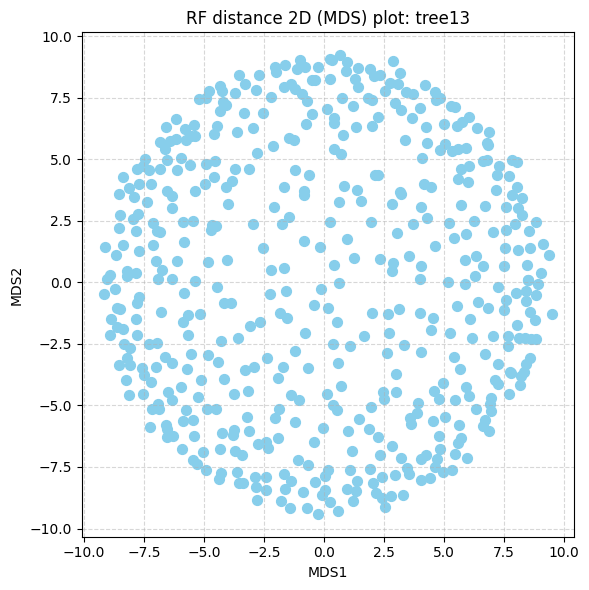

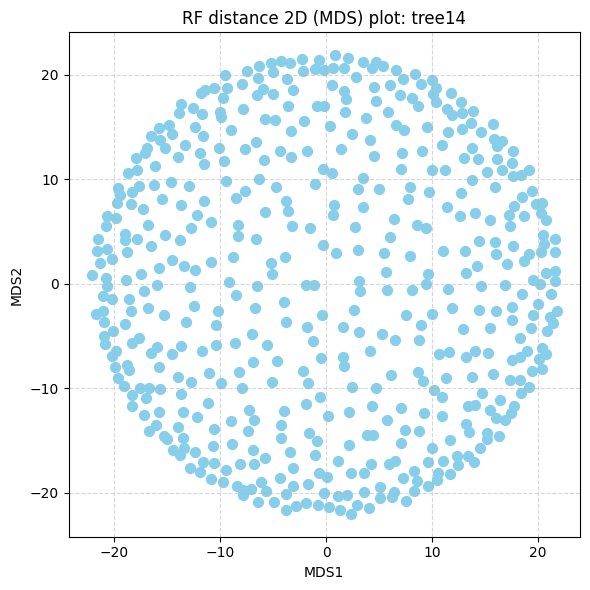

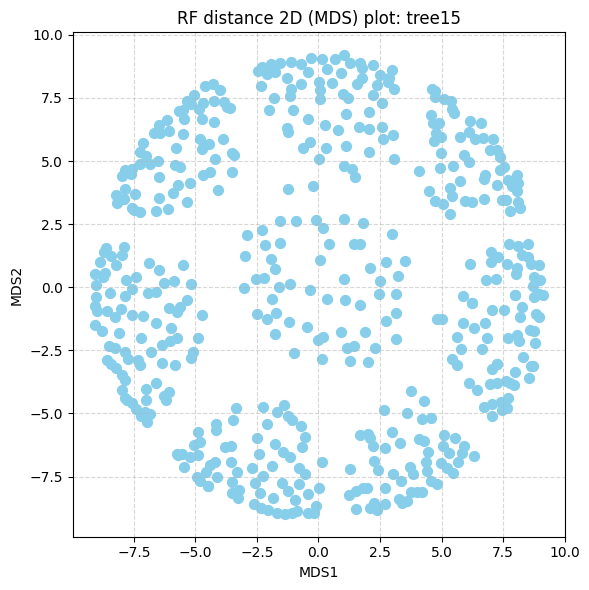

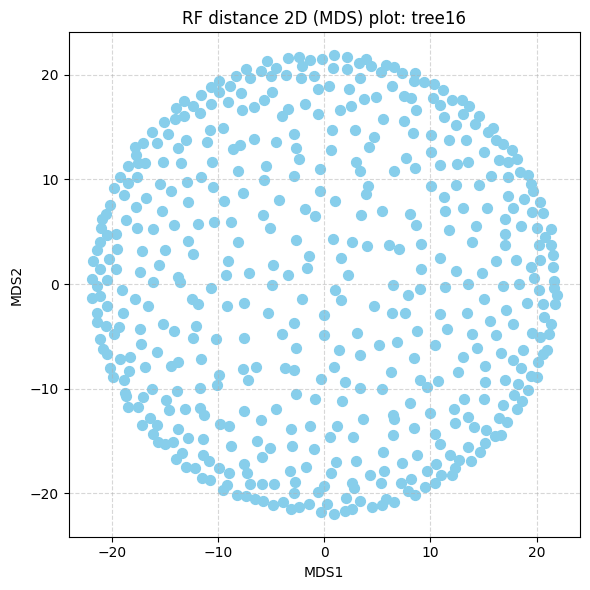

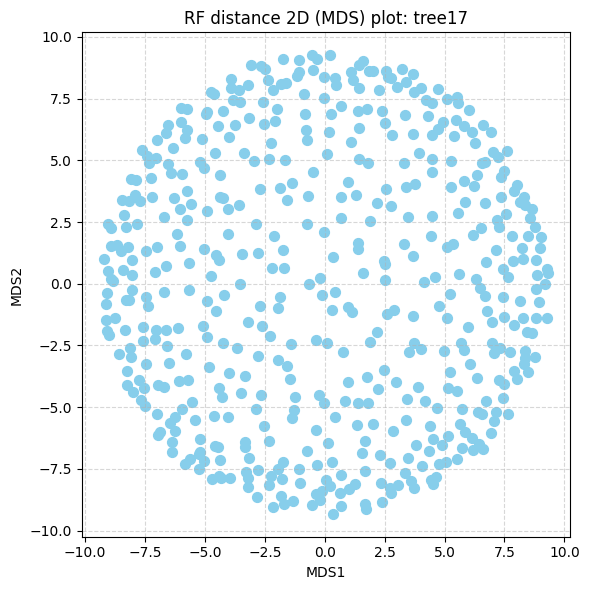

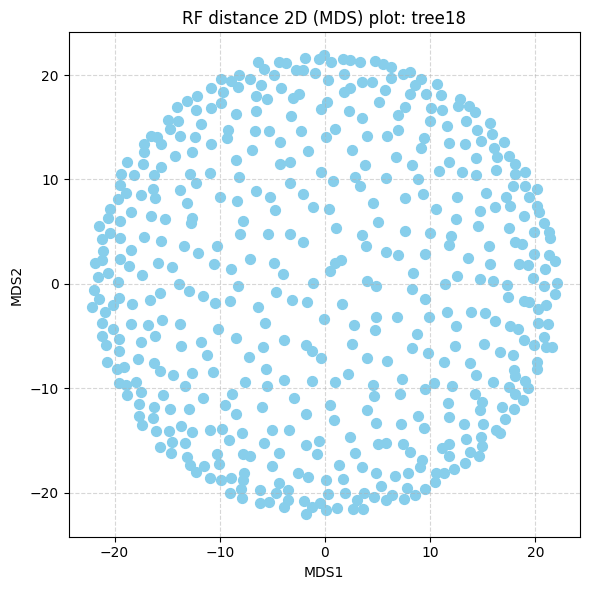

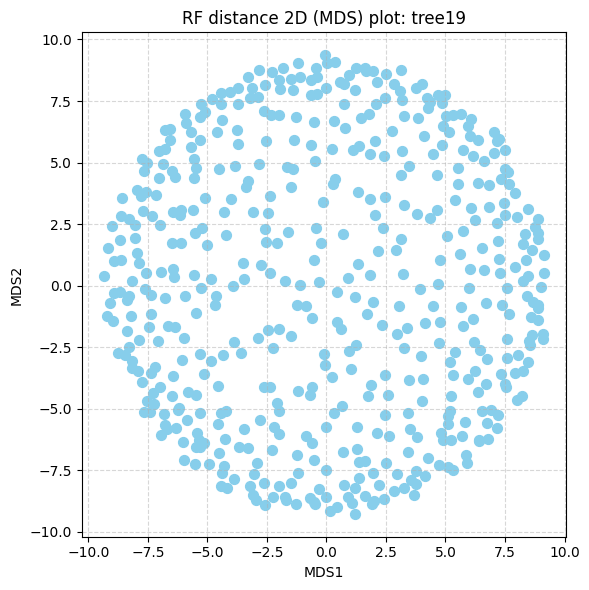

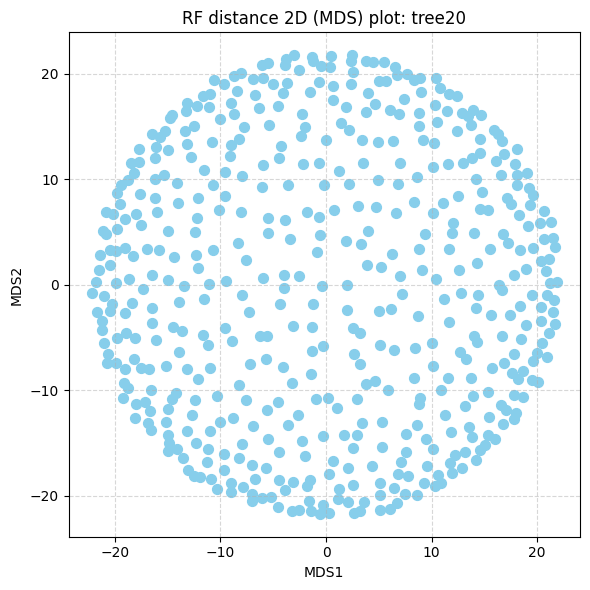

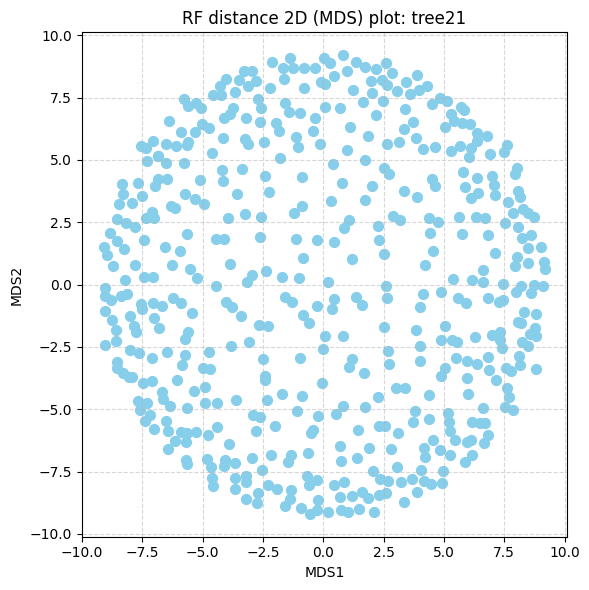

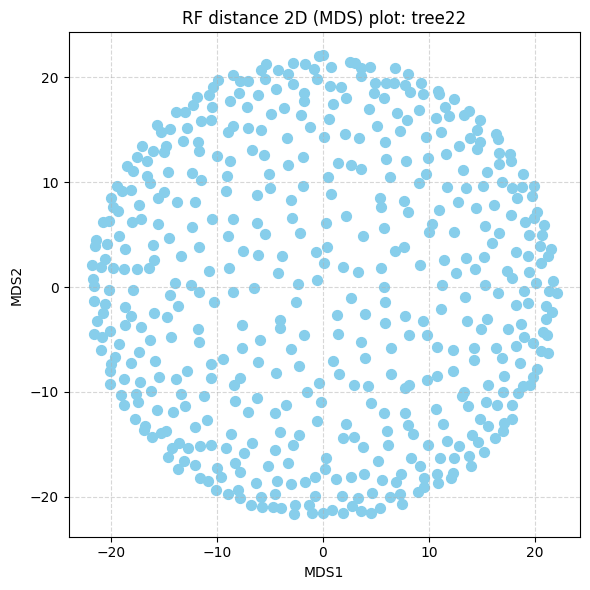

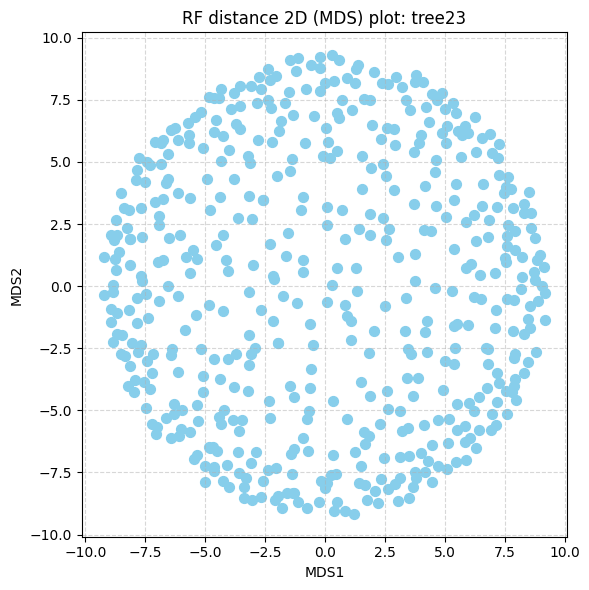

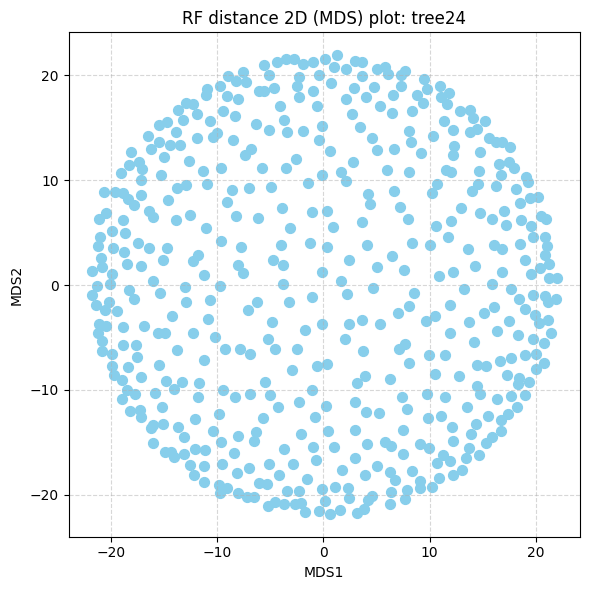

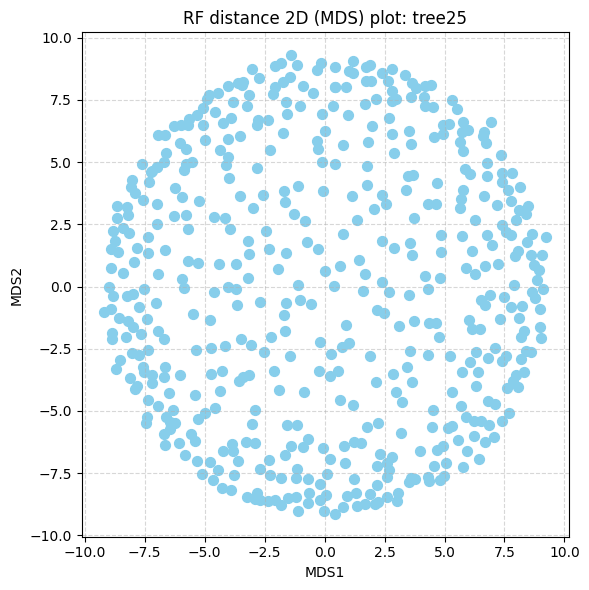

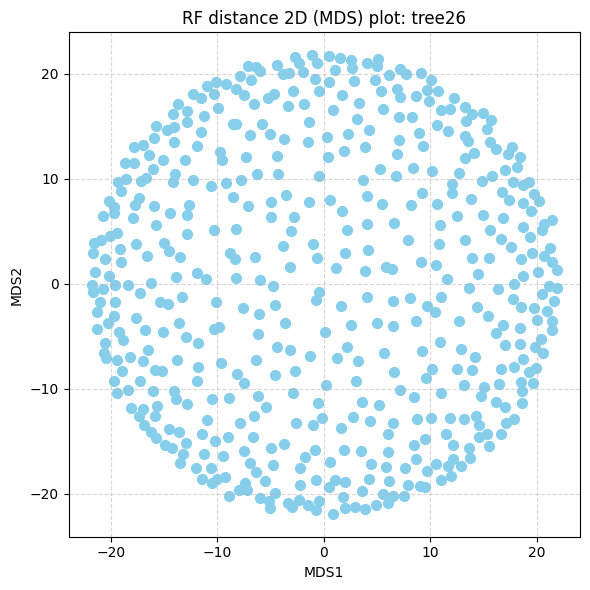

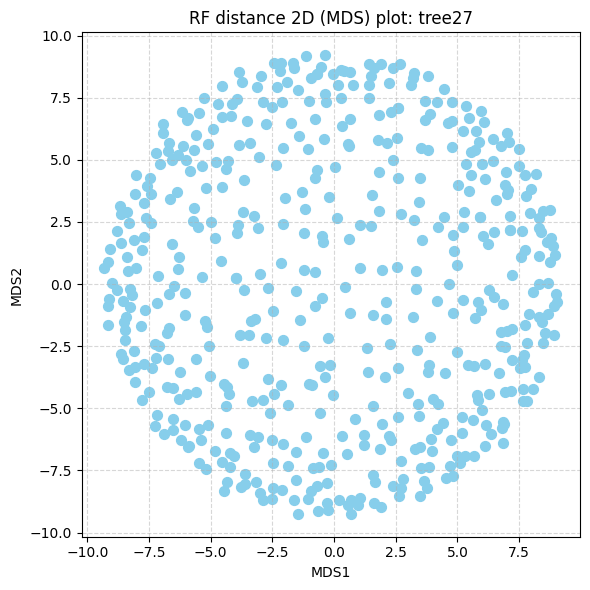

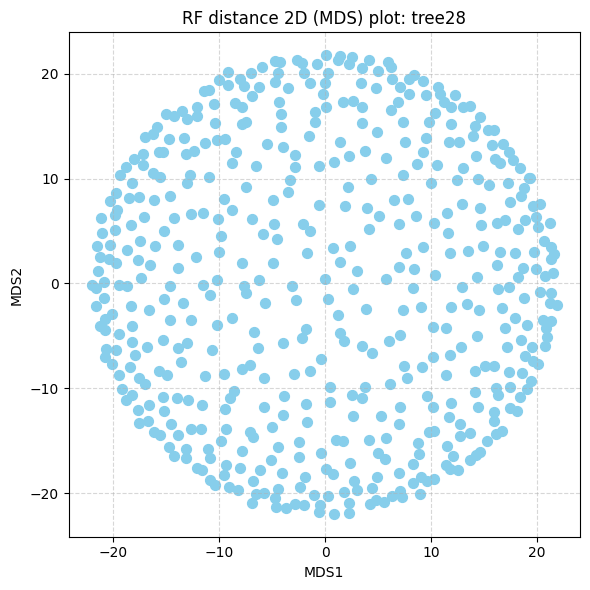

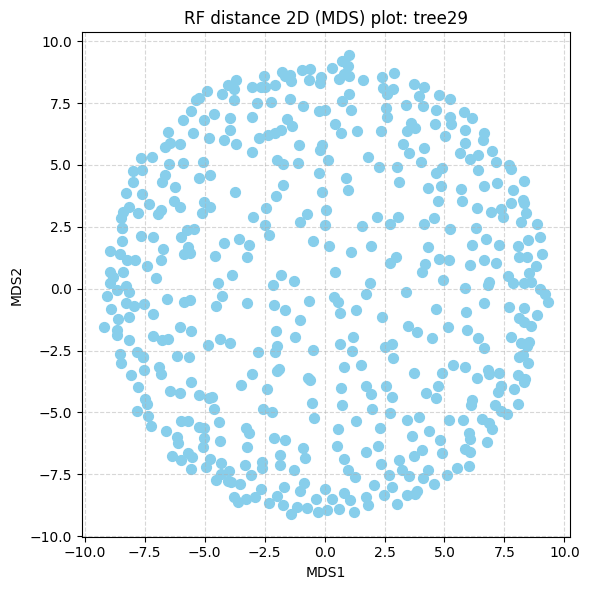

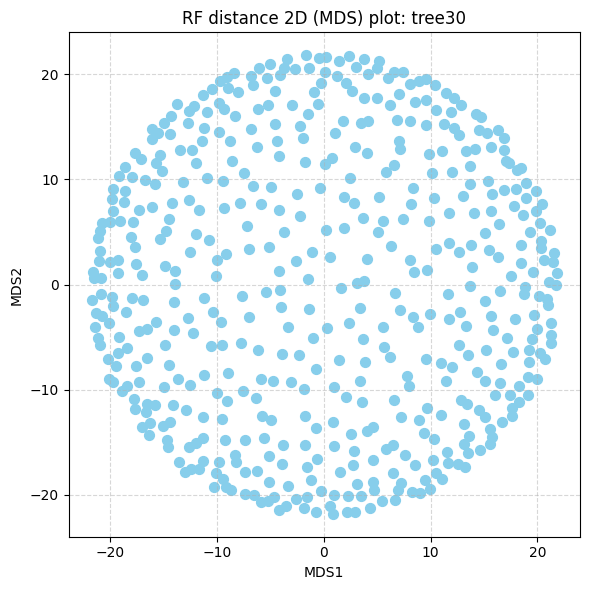

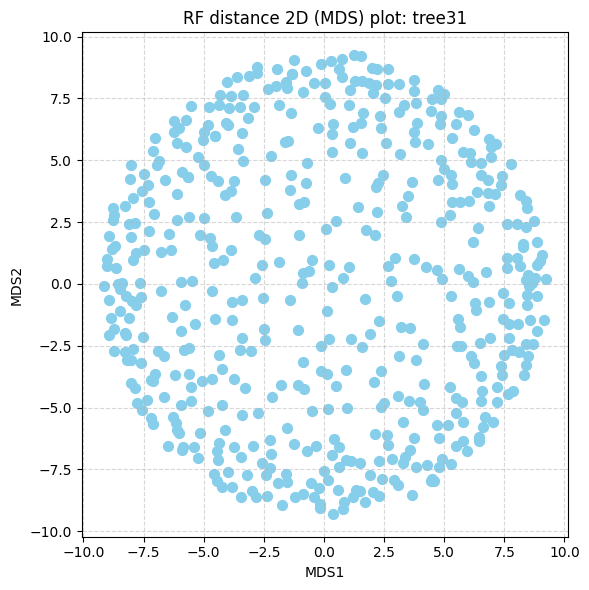

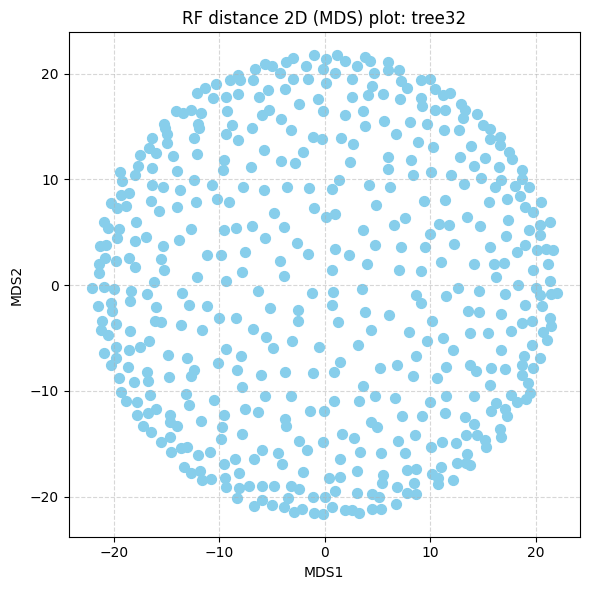

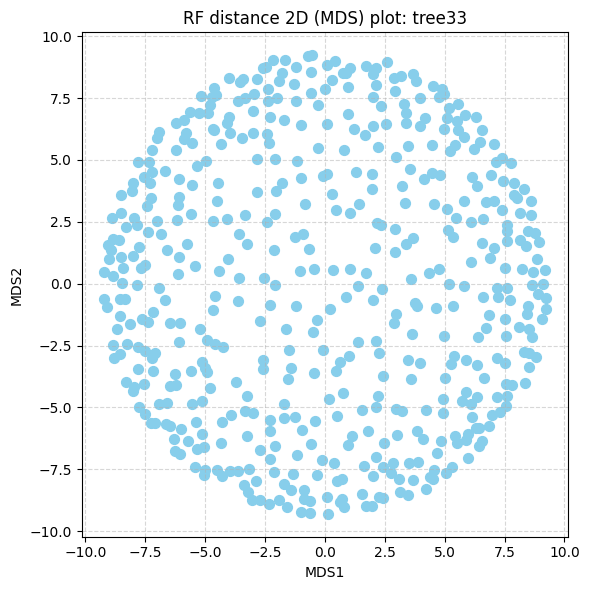

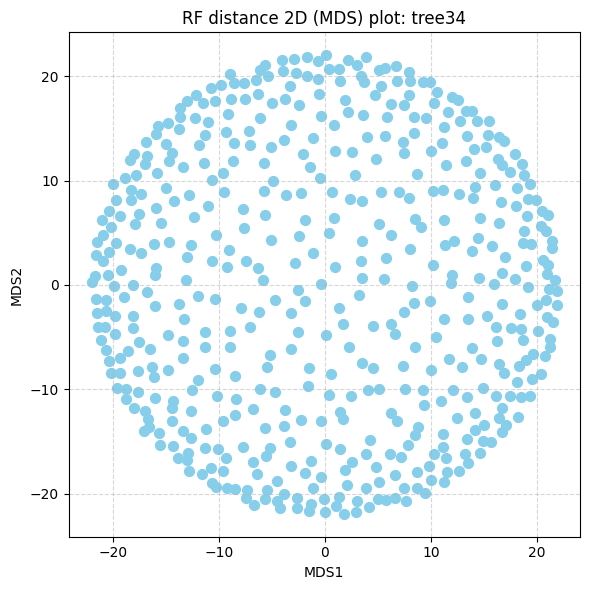

In [7]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# 모델별 RF distance를 2D embedding
for model_name, rf_mat in rf_matrices.items():
    # scikit-learn MDS는 거리 행렬 입력 시 dissimilarity='precomputed' 필요
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    coords = mds.fit_transform(rf_mat.values)  # n_trees x 2

    plt.figure(figsize=(6,6))
    plt.scatter(coords[:,0], coords[:,1], c='skyblue', s=50)
    plt.title(f"RF distance 2D (MDS) plot: {model_name}")
    plt.xlabel("MDS1")
    plt.ylabel("MDS2")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()